# Problema de la divergencia

Con las ténicas vistas hasta el momento podemos generar acciones de alto nivel o comandos relativos a la dinámica del sistema a fin de realizar tareas diversas. Por ejemplo, el RRT nos entrega la secuencia en el tiempo de fuerzas y torques que se deben aplicar. La forma más rápida de aplicar estos comandos es mediante un **control de lazo abierto**, donde se aplican los comandos de acuerdo al instante de tiempo en que se determinó la trayectoria. Sin embargo, existen innumerables variables que afectan la precisión con la que se ejecutan dichos comandos, esto tiene consecuencia en una desviación de la trayectoria ejecutada con respecto a la trayectoria deseada. 

> Ejercicio: completar el controlador de lazo abierto

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories


In [2]:
class Monorotor:
    def __init__(self, m=1.0):
        self.m = m
        self.g = 9.81
        self.thrust = 0.0
        # z, z_dot
        self.X = np.array([0.0,0.0])
      
    @property
    def z(self): 
        return self.X[0]
    
    @property
    def z_dot(self):
        return self.X[1]
    
    @property
    def z_dot_dot(self): 
        f_net = self.m * self.g - self.thrust
        return f_net / self.m
    
    def advance_state(self, dt):
        X_dot =np.array([
            self.z_dot, 
            self.z_dot_dot])
        
        self.X = self.X + X_dot * dt
        return self.X

## Control a lazo abierto

Retomando el caso del monorotor, donde éste solo se puede desplazar de forma vertical y suponemos que su estado es $x=[z,\dot{z}]$. Podemos implementar un control a lazo abierto. Este control recibe como entrada una trayectoria objetivo, la masa y el estado inicial para poder calcular el empuje requerido en cada instate de tiempo. Para este ejemplo, suponemos que el estado inicial es $x_0 = [z=0, \dot{z}=0]$

En el siguiente código la función `thrust_control` se llama en cada instante de tiempo y su tarea es la implementación del control, es decir alcanzar `target_z` el en el tiempo `dt`.

In [3]:
class OpenLoopController:
    
    def __init__(self, vehicle_mass, initial_state=np.array([0,0])): 
        self.vehicle_mass  = vehicle_mass 
        
        self.vehicle_state = initial_state 
        self.g = 9.81
    
    def thrust_control(self, target_z, dt):
        """
        Returns a thrust which will be commanded to 
        the vehicle. This thrust should cause the vehicle
        to be at target_z in dt seconds.
        
        The controller's internal model of the vehicle_state
        is also updated in this method.
        """
        # 1. find target velocity needed to get to target_z
        target_z_dot = pass
        
        # 2. find target acceleration needed
        target_z_dot_dot = pass
        
        # 3. find target NET force
        target_f_net = pass
        
        # 4. find target thrust. Recall this equation:
        #    F_net = mg - thrust
        thrust = pass
        
        # 5. update controller's internal belief of state
        self.vehicle_state += np.array([delta_z, delta_z_dot])
        
        return thrust 


## Ejecución del control 

Dado el control de lazo abierto implementado, tratemos de seguir la función sinusoidal.

$$z(t) = 0.5\cos(2t)-0.5$$

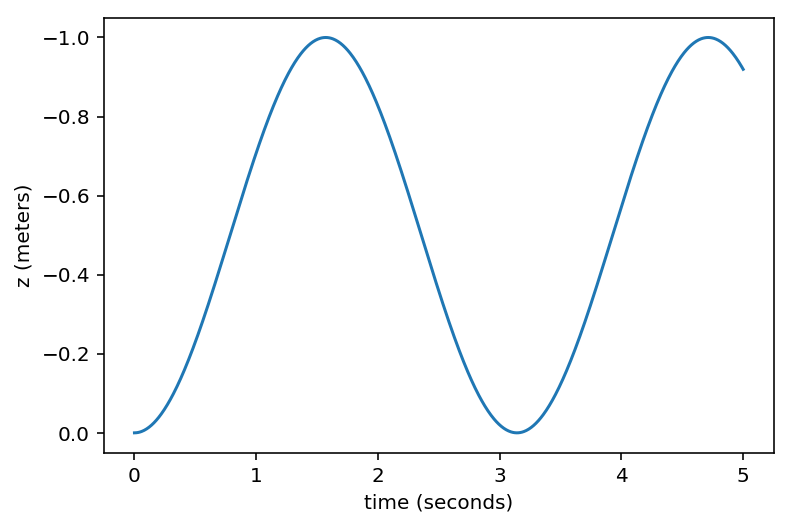

In [4]:
def ruta(t):
    z_path = 0.5*np.cos(2*t)-0.5
    return z_path

# Generar y visualizar la ruta objetivo:
total_time = 5.0
t = np.linspace(0.0,total_time,1000)
dt = t[1] - t[0]
z_path = ruta(t)

#plt.figure(figsize=(5,5))
plt.ylabel("z (meters)")
plt.xlabel("time (seconds)")
plt.gca().invert_yaxis()
plt.plot(t,z_path)
plt.show()

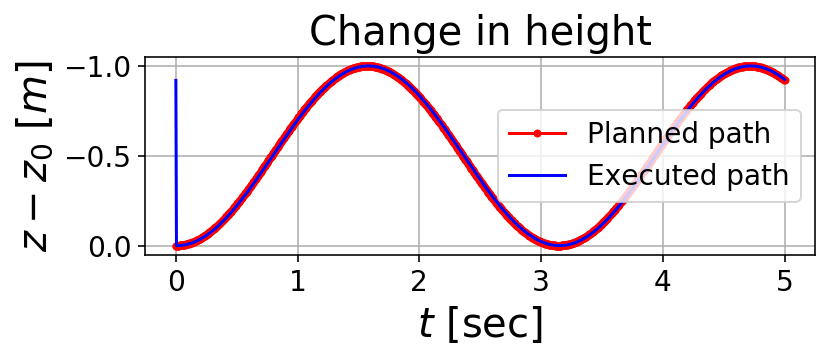

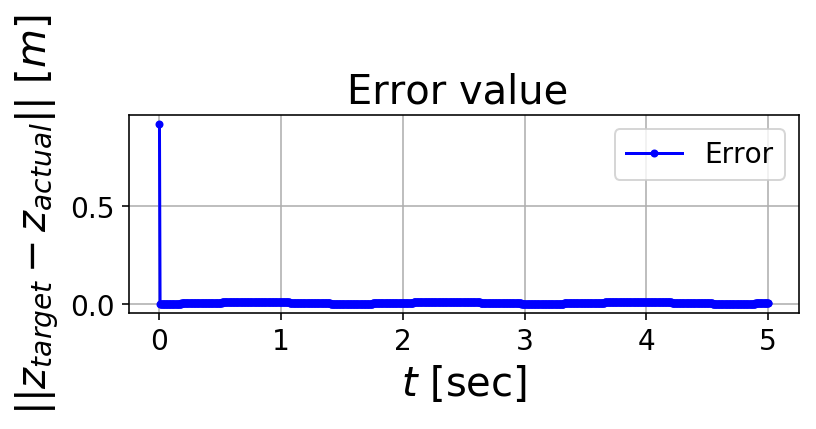

In [5]:
# Simular la ejecución
drone = Monorotor()
drone_start_state = drone.X
drone_mass = drone.m

# Instanciemos el controlador
controller = OpenLoopController(drone_mass, drone_start_state)

# Ejecutar simulación
drone_state_history = []
for target_z in z_path:
    drone_state_history.append(drone.X)
    thrust = controller.thrust_control(target_z, dt)
    drone.thrust = thrust
    drone.advance_state(dt)

# Graficar
z_actual = [h[0] for h in drone_state_history] 
plotting.compare_planned_to_actual(z_actual, z_path, t)

Todo parece perfecto, sin embargo, en un entorno real no es posible modelar de forma perfecta, por lo cual, incluiremos un un pequeño ruido al modelo. En este caso, supondremos que no tenemos una forma exacta de medir la masa de nuestro monorotor y que tenemos un error del 1%.

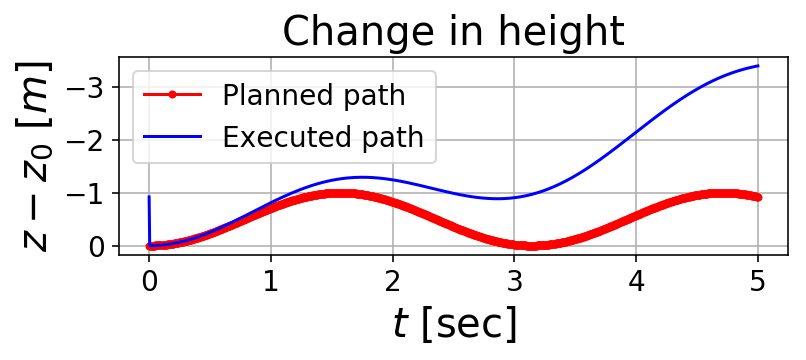

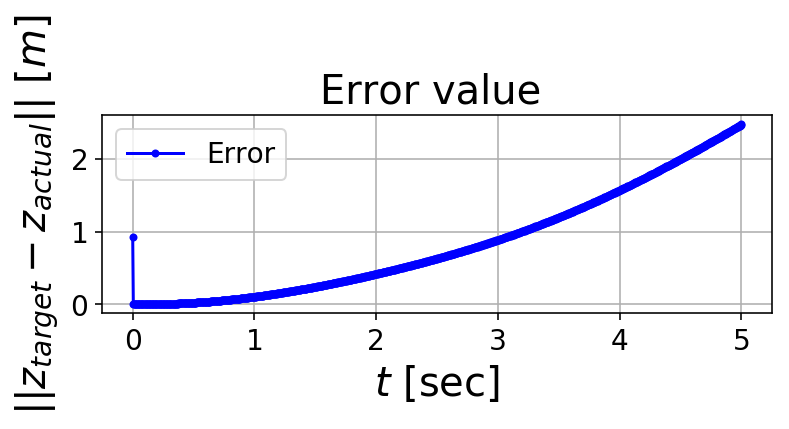

In [9]:
# Incluir error en la medición de la masa
MASS_ERROR = 0.02

drone = Monorotor()
drone_start_state = drone.X
drone_mass = drone.m

# Esto implica que la masa que suponemos en el modelo difiere un poco de la masa real, 
# algo que pasa continuamente en la realidad
perceived_mass = drone_mass + drone_mass * MASS_ERROR
controller = OpenLoopController(perceived_mass, drone_start_state)

drone_state_history = []
for target_z in z_path:
    drone_state_history.append(drone.X)
    thrust = controller.thrust_control(target_z, dt)
    drone.thrust = thrust
    drone.advance_state(dt)

z_actual = [h[0] for h in drone_state_history] 
plotting.compare_planned_to_actual(z_actual, z_path, t)

Como podemos darnos cuenta, el vehículo no sigue la ruta de forma exacta ocasionando una divergencia con respecto al comportamiento esperado. Incluso, el error se incrementa de forma no lineal conforme pasa el tiempo. Por tanto, podemos concluir que en un control de lazo abierto las imprecisiones o perturbaciones en el modelo causarán una divergencia indeseable.

(ACTIVIDAD): Modifica en el código el error en la medición de la masa y anota las observaciones.